In [72]:
name = None
work_path = r"C:\Ariel codes\networks\final project\Networks_Final_Project\resources"

In [73]:
# importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
#time delays between 2 consecutive messages
def add_delays(df: pd.DataFrame):
    df["Time_delay"] = (df["Time"].diff().fillna(0)).round(6)

#packets length diffs 2 consecutive messages
def add_lengths(df: pd.DataFrame):
    df["Length_diff"] = abs(df["Length"].diff()).fillna(0)


def reformat_columns(df: pd.DataFrame):
    df["No."] = df["No."].astype(float)
    df["Time"] = df["Time"].astype(float)
    df["Length"] = df["Length"].astype(float)

In [75]:
def load_csv(number):
    if number == '1':
        name = "whatsappMessagesCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("---------Messages----------")
    elif number == '2':
        name = "whatsappImagesCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("---------Images----------")
    elif number == '3':
        name = "whatsappAudioCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("---------Audio----------")
    elif number == '4':
        name = "whatsappVideosAndFilesCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("---------Videos and Files----------")

    df = pd.read_csv(path, sep=',', header=0,
                     usecols=["No.", "Time", "Source", "Destination", "Protocol", "Length", "Info"])
    reformat_columns(df)
    add_delays(df)
    add_lengths(df)
    print(df.head())
    return df, name

In [76]:
def plot_activity_trends(df):
    # Plot the message count over time using a line chart
    plt.figure(figsize=(15, 4))
    plt.plot(df["Time"], df["Length"], marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Message Count and Activity Trends")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [77]:
def rows_of_probably_noisy_packets(df):
    temp_df = df.copy()
    
    # Extract the first number from the "Source" column
    temp_df["FirstNumber"] = temp_df["Source"].str.split('.').str[0]

    # Compute median lengths for each 'FirstNumber'
    median_lengths = temp_df.groupby('FirstNumber')['Length'].median()

    # Filter the 'FirstNumber' values where the median is greater than 500
    desired_nums = median_lengths[median_lengths > 500].index.tolist()

    desired_ids = temp_df[(temp_df['FirstNumber'].isin(desired_nums)) | (temp_df['Source'].str.startswith(('157', '10')))].Source.tolist()
    
    row_numbers = df[df["Destination"].isin(desired_ids) & ((temp_df['FirstNumber'].isin(desired_nums)) | (temp_df['Source'].str.startswith(('157', '10'))))].index.tolist()

    return row_numbers

In [78]:
#bar plot of length packetlength changes in time
def bar_plot(df):
    plt.figure(figsize=(9, 4))
    plt.bar(df["Time"], df["Length"])
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [79]:
#filtering all packets with length above a certain threshold
def filter_length_above_given(df: pd.DataFrame, given: int):
    filtered_df = df[df["Length"] > given]
    return filtered_df

In [80]:
#filtering all packets with length below a certain threshold
def filter_length_below_given(df: pd.DataFrame, given: int):
    filtered_df = df[df["Length"] < given]
    return filtered_df

In [81]:
#counting the sizes of packets (num of packets in a certain ranges) 
def count_length_ranges(df: pd.DataFrame):
    ranges = {
        "0-50": (0, 50),
        "51-100": (51, 100),
        "100-500": (101, 500),
        "501-1000": (501, 1000),
        "1001-1500": (1001, 1500),
        ">1500": (1501, float("inf"))
    }
    
    range_counts = {range_name: 0 for range_name in ranges}
    
    for range_name, (lower, upper) in ranges.items():
        range_counts[range_name] = ((df["Length"] >= lower) & (df["Length"] <= upper)).sum()
    
    return range_counts

In [82]:
def plot_length_range_counts(length_range_counts):
    range_names = list(length_range_counts.keys())
    counts = list(length_range_counts.values())
    
    plt.figure(figsize=(5, 4))
    plt.bar(range_names, counts)
    plt.xlabel("Length Range")
    plt.ylabel("Count")
    plt.title("Count of Cells in Each Length Range")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [83]:
#plot of packet length with the frequency of this packet length
def plot_length_histogram(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.hist(df["Length"], bins=df["Length"].nunique(), edgecolor="black")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.title("Length Histogram")
    plt.show()

In [84]:
def remove_middle_row(df: pd.DataFrame, threshold: int = 500, lendth_diff: int = 20):
    # Reset the index to ensure a continuous integer index
    df = df.reset_index(drop=True)
    
    rows_to_remove = []

    for i in range(1, len(df) - 1):
        # Using .iloc for positional indexing
        length_diff = abs(df.iloc[i - 1]["Length"] - df.iloc[i + 1]["Length"])
        
        first_condition = (length_diff <= lendth_diff) and \
                          (df.iloc[i - 1]["Length"] > threshold) and \
                          (df.iloc[i + 1]["Length"] > threshold)
        
        second_condition = (df.iloc[i - 1]["Length"] > threshold) and \
                           (df.iloc[i + 1]["Length"] > threshold) and \
                           (df.iloc[i]["Length"] < threshold)
        
        if (first_condition or second_condition):
            rows_to_remove.append(i)

    cleaned_df = df.drop(rows_to_remove)
    cleaned_df.reset_index(drop=True, inplace=True)
    
    return cleaned_df


Please select which Whatsapp Group you want to clean:
1 - Mixed messages (a bit from everything)
2 - Mostly Images
3 - Mostly Audio
4 - Mostly videos and files
5 - Exit
4
---------Videos and Files----------
   No.      Time          Source     Destination Protocol  Length  \
0  1.0  0.000000       10.0.2.15  74.125.133.188      TCP    54.0   
1  2.0  0.000498  74.125.133.188       10.0.2.15      TCP    60.0   
2  3.0  0.757026       10.0.2.15  157.240.214.60  TLSv1.2   122.0   
3  4.0  0.757539  157.240.214.60       10.0.2.15      TCP    60.0   
4  5.0  1.022455  157.240.214.60       10.0.2.15  TLSv1.2   112.0   

                                                Info  Time_delay  Length_diff  
0   40272  >  5228 [ACK] Seq=1 Ack=1 Win=62780 Len=0    0.000000          0.0  
1  [TCP ACKed unseen segment] 5228  >  40272 [ACK...    0.000498          6.0  
2                                   Application Data    0.756528         62.0  
3   443  >  59460 [ACK] Seq=1 Ack=69 Win=65535 Len=0    0.

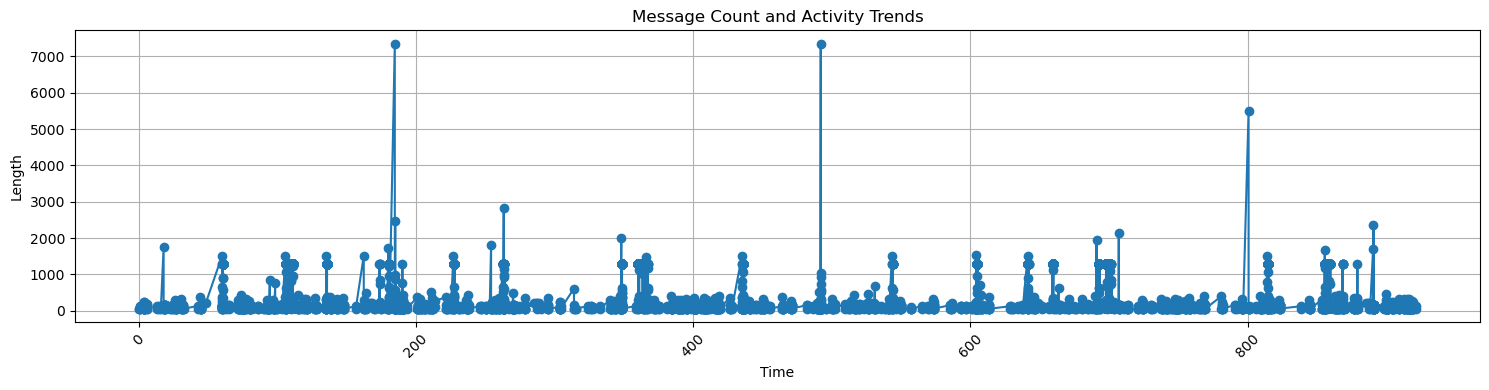

In [118]:
invalid = True
while invalid:
    answer = input("Please select which Whatsapp Group you want to clean:\n"
                           "1 - Mixed messages (a bit from everything)\n"
                           "2 - Mostly Images\n"
                           "3 - Mostly Audio\n"
                           "4 - Mostly videos and files\n"
                           "5 - Exit\n")
    if answer != '1' and answer != '2' and answer != '3' and answer != '4' and answer != '5':
        print("Invalid value. Please enter a valid number\n")
    elif answer == '5':
        invalid = False
        print("Goodbye")
    else:
        invalid = False
        df, name = load_csv(answer)
        plot_activity_trends(df)

In [119]:
df

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,10.0.2.15,74.125.133.188,TCP,54.0,40272 > 5228 [ACK] Seq=1 Ack=1 Win=62780 Len=0,0.000000,0.0
1,2.0,0.000498,74.125.133.188,10.0.2.15,TCP,60.0,[TCP ACKed unseen segment] 5228 > 40272 [ACK...,0.000498,6.0
2,3.0,0.757026,10.0.2.15,157.240.214.60,TLSv1.2,122.0,Application Data,0.756528,62.0
3,4.0,0.757539,157.240.214.60,10.0.2.15,TCP,60.0,443 > 59460 [ACK] Seq=1 Ack=69 Win=65535 Len=0,0.000513,62.0
4,5.0,1.022455,157.240.214.60,10.0.2.15,TLSv1.2,112.0,Application Data,0.264916,52.0
...,...,...,...,...,...,...,...,...,...
26553,26554.0,919.056976,157.240.214.60,10.0.2.15,TLSv1.2,151.0,Application Data,0.023875,91.0
26554,26555.0,919.061572,10.0.2.15,157.240.214.60,TLSv1.2,150.0,Application Data,0.004596,1.0
26555,26556.0,919.061946,157.240.214.60,10.0.2.15,TCP,60.0,443 > 59460 [ACK] Seq=101607 Ack=71073 Win=6...,0.000374,90.0
26556,26557.0,921.477483,157.240.214.60,10.0.2.15,TLSv1.2,131.0,Application Data,2.415537,71.0


In [120]:
'''protocols that appeared in some recordings, but are not containing messages content:
Elasticsearch: Not a communication protocol but rather a search engine. Elasticsearch operates over HTTP, so the packets might be associated with search queries or indexing operations.
DNS: Domain Name System, used for domain name resolution. its packets doesn't contain message content
SSDP: Simple Service Discovery Protocol, primarily used with UPnP (Universal Plug and Play). It's not related to WhatsApp messages.
HTTP: The foundation of any data exchange on the Web. WhatsApp might use HTTP for certain services, but not likely for message transmission as it would be less secure.
NTP: Network Time Protocol. It's used to synchronize the clocks of computer systems over packet-switched, variable-latency data networks. This would not contain WhatsApp message content.
MDNS: Multicast DNS. Used for resolving hostnames to IP addresses within small networks that do not include a local name server. Not related to WhatsApp message content.
ICMPv6: It's used for diagnostic purposes, error reporting, and other operations related to the management of IP networks.wouldn't contain the content of WhatsApp messages.
Thus, we will filter out the rows wherethe protocol is one of the listed above'''

# List of protocols to exclude
protocols_to_exclude = ['Elasticsearch', 'DNS', 'SSDP', 'HTTP', 'NTP', 'MDNS', 'ICMPv6']

# Filter rows
df = df[~df['Protocol'].isin(protocols_to_exclude)]

In [121]:
# Create a true copy of df
temp_df = df.copy()

# Extract the first number from the "Source" column
temp_df["FirstNumber"] = temp_df["Source"].str.split('.').str[0]

# Group by both FirstNumber and Source to get individual counts, average packet length, and most used protocol
result_df = temp_df.groupby(["FirstNumber", "Source"]).agg(
    Count=('Source', 'size'),
    MedianPacketLength=('Length', 'median'),
    MostUsedProtocol=('Protocol', lambda x: x.mode()[0] if not x.mode().empty else None)  # Use mode to find the most frequent protocol
).reset_index()

# Now group by FirstNumber alone to sum the counts, get the average packet length, and get the most used protocol
result = result_df.groupby("FirstNumber").agg(
    TotalCount=('Count', 'sum'),
    OverallMedianPacketLength=('MedianPacketLength', 'median'),
    OverallMostUsedProtocol=('MostUsedProtocol', lambda x: x.mode()[0] if not x.mode().empty else None)
).reset_index()

result = result.sort_values(by='TotalCount', ascending=False).reset_index(drop=True)

print(result)

  FirstNumber  TotalCount  OverallMedianPacketLength OverallMostUsedProtocol
0         213       15050                     1274.0                    QUIC
1          10        8662                       80.0                    QUIC
2         157        1092                      314.0                    QUIC
3         142          28                       78.0                    QUIC
4          74          22                       60.0                     TCP
5         172           8                      191.0                    QUIC
6          35           8                       60.0                     TCP
7         185           4                       60.0                     TCP
8          91           4                       60.0                     TCP


In [122]:
df = df.loc[rows_of_probably_noisy_packets(df)]

In [123]:
df = df[df["Length"]<10000] #probably an error packet, median size of big packets is about 1200
df = df[~(df['Info'].str.contains('Len=0', case=False, na=False))]

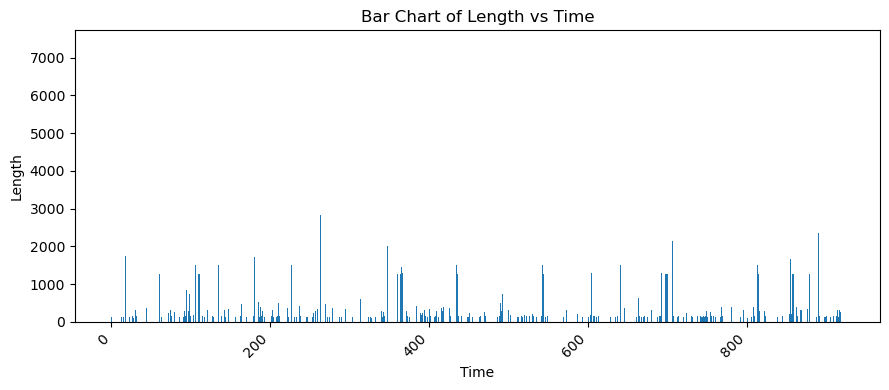

In [124]:
bar_plot(df)

In [125]:
grouped_df = df.groupby('Info').size().reset_index(name='Count')
sorted_df = grouped_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

sorted_df

,Info,Count
0,Protected Payload (KP0),15108
1,"Protected Payload (KP0), DCID=be8100070d357b3f",2427
2,"Protected Payload (KP0), DCID=9281000411119a48",2028
3,"Protected Payload (KP0), DCID=a381000a2002cda7",1484
4,Application Data,902
...,...,...
105,"Initial, DCID=75c94fbd9209ac18, PKN: 1, PADDIN...",1
106,"Initial, DCID=98e914ea5140adb7, PKN: 1, PING, ...",1
107,"Initial, DCID=98ef1c47f5dc6193, PKN: 1, PADDIN...",1
108,"Handshake, DCID=9381000a205c4d3d",1


In [126]:
df = df[~df['Info'].str.contains('Initial', case=False, na=False)]
df = df[~(df['Info'].str.contains('Change Cipher Spec', case=False, na=False) & (df['Length'] <= 250))]
df = df[~(df['Info'].str.lower() == 'client hello')]
df = df[~(df['Info'].str.contains('Server Hello', case=False, na=False) & (df['Length'] <= 250))]
cleaned_df = remove_middle_row(df)

In [127]:
df.head(20)

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
2,3.0,0.757026,10.0.2.15,157.240.214.60,TLSv1.2,122.0,Application Data,0.756528,62.0
4,5.0,1.022455,157.240.214.60,10.0.2.15,TLSv1.2,112.0,Application Data,0.264916,52.0
6,7.0,3.541869,10.0.2.15,157.240.214.60,TLSv1.2,237.0,Application Data,2.519289,183.0
11,12.0,3.772105,157.240.214.60,10.0.2.15,TLSv1.2,149.0,Application Data,0.157797,75.0
22,23.0,6.127310,157.240.214.60,10.0.2.15,TLSv1.2,196.0,Application Data,2.134439,136.0
24,25.0,6.192515,10.0.2.15,157.240.214.60,TLSv1.2,154.0,Application Data,0.065180,100.0
26,27.0,13.295676,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,7.101320,64.0
28,29.0,15.029622,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,1.733058,64.0
30,31.0,16.013996,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,0.983323,64.0
32,33.0,18.018777,10.0.2.15,157.240.214.60,TLSv1.2,1759.0,Application Data,2.003973,1699.0


In [128]:
df.drop(columns=["Time_delay","Length_diff"], inplace=True)
df.to_csv(work_path + "/CLEAN/" + name + 'Clean.csv', index=False)